# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [75]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [76]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [77]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [78]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [79]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [80]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [81]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [117]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [103]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [84]:
# don't shuffle  

"""import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(X, y, seed = 90)"""

'import random \ndef shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(X, y, seed = 90)'

In [85]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [86]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [89]:
original_X = X
original_Y = y 

In [97]:
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(original_X, original_Y, seed=65)

Epoch 1/75
3/3 [==============================] - 0s 181ms/step - loss: 0.6715 - accuracy: 0.5750 - precision_148: 0.5345 - recall_148: 0.8158 - val_loss: 0.6305 - val_accuracy: 0.6000 - val_precision_148: 0.7500 - val_recall_148: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 179ms/step - loss: 0.6252 - accuracy: 0.7625 - precision_148: 0.7879 - recall_148: 0.6842 - val_loss: 0.7082 - val_accuracy: 0.6000 - val_precision_148: 0.6429 - val_recall_148: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 172ms/step - loss: 0.5978 - accuracy: 0.7500 - precision_148: 0.6875 - recall_148: 0.8684 - val_loss: 0.6818 - val_accuracy: 0.5500 - val_precision_148: 0.6154 - val_recall_148: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.5410 - accuracy: 0.7750 - precision_148: 0.7632 - recall_148: 0.7632 - val_loss: 0.8839 - val_accuracy: 0.6500 - val_precision_148: 0.6923 - val_recall_148: 0.7500
Epoch 5/75
3/3 [==============================] 

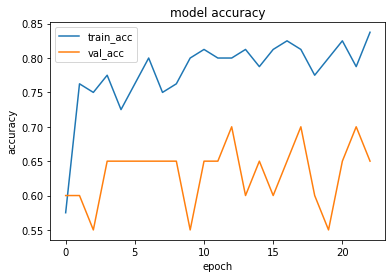

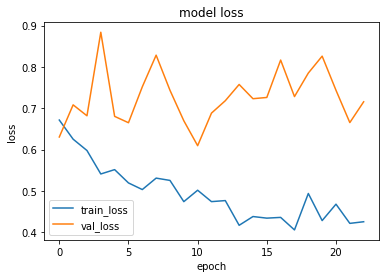

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.63816273]]


1it [00:00, 10433.59it/s]


prediction for video armflapping_3.mov is [[0.7568907]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.7378219]]


1it [00:00, 10754.63it/s]


prediction for video control_1.mov is [[0.16486236]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.15200207]]


1it [00:00, 14027.77it/s]


prediction for video control_3.mov is [[0.1517047]]
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6927 - accuracy: 0.5750 - precision_149: 0.5926 - recall_149: 0.4103 - val_loss: 0.6333 - val_accuracy: 0.7000 - val_precision_149: 0.8571 - val_recall_149: 0.5455
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6456 - accuracy: 0.6500 - precision_149: 0.6571 - recall_149: 0.5897 - val_loss: 0.6096 - val_accuracy: 0.7500 - val_precision_149: 0.8000 - val_recall_149: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.5904 - accuracy: 0.7500 - precision_149: 0.7568 - recall_149: 0.7179 - val_loss: 0.6093 - val_accuracy: 0.7500 - val_precision_149: 0.8000 - val_recall_149: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.5598 - accuracy: 0.7375 - precision_149: 0.7500 - recall_149: 0.6923 - val_loss: 0.5856 - val_accuracy: 0.7000 - val_precision_149: 0.7273 - val_recall_149: 0.7

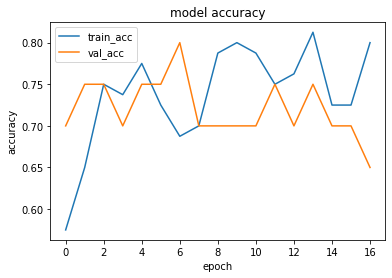

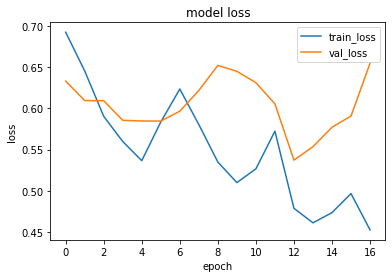

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.5118828]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5571181]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.57445616]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.4536648]]


1it [00:00, 18315.74it/s]


prediction for video control_2.mov is [[0.42643994]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.3987373]]
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.7322 - accuracy: 0.5250 - precision_150: 0.5909 - recall_150: 0.3095 - val_loss: 0.6900 - val_accuracy: 0.4500 - val_precision_150: 0.4211 - val_recall_150: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6932 - accuracy: 0.5250 - precision_150: 0.5278 - recall_150: 0.9048 - val_loss: 0.6664 - val_accuracy: 0.7500 - val_precision_150: 0.6154 - val_recall_150: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6407 - accuracy: 0.6750 - precision_150: 0.6600 - recall_150: 0.7857 - val_loss: 0.6659 - val_accuracy: 0.7500 - val_precision_150: 0.6364 - val_recall_150: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6354 - accuracy: 0.7125 - precision_150: 0.7317 - recall_150: 0.7143 - val_loss: 0.6666 - val_accuracy: 0.8000 - val_precision_150: 0.7000 - val_recall_150: 0.8

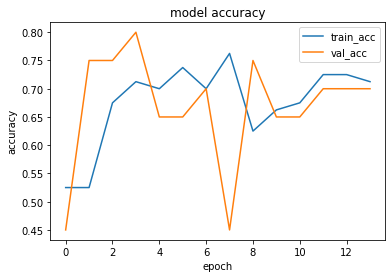

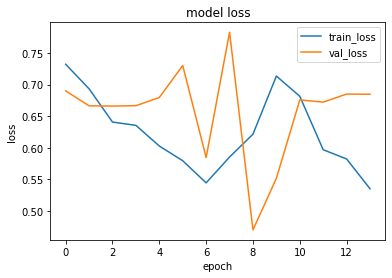

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.61519486]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.756746]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.7769395]]


1it [00:00, 13315.25it/s]


prediction for video control_1.mov is [[0.4918329]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.43853766]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.4104413]]
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7642 - accuracy: 0.4250 - precision_151: 0.4333 - recall_151: 0.3095 - val_loss: 0.6908 - val_accuracy: 0.3500 - val_precision_151: 0.3529 - val_recall_151: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6625 - accuracy: 0.5875 - precision_151: 0.5616 - recall_151: 0.9762 - val_loss: 0.6650 - val_accuracy: 0.4500 - val_precision_151: 0.4118 - val_recall_151: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6338 - accuracy: 0.6375 - precision_151: 0.6000 - recall_151: 0.9286 - val_loss: 0.6463 - val_accuracy: 0.7500 - val_precision_151: 0.8000 - val_recall_151: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5867 - accuracy: 0.7500 - precision_151: 0.7619 - recall_151: 0.7619 - val_loss: 0.5837 - val_accuracy: 0.8000 - val_precision_151: 0.8333 - val_recall_151: 0.6

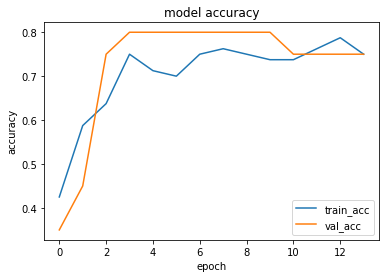

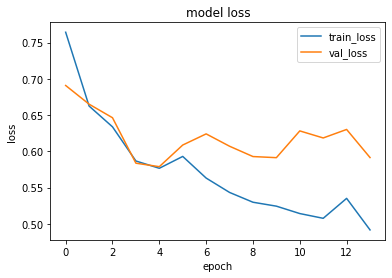

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.40028754]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.47980452]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.7197354]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.31091017]]


1it [00:00, 15420.24it/s]


prediction for video control_2.mov is [[0.27026147]]


1it [00:00, 12483.05it/s]


prediction for video control_3.mov is [[0.2851106]]
Epoch 1/75
3/3 [==============================] - 0s 174ms/step - loss: 0.6840 - accuracy: 0.5375 - precision_152: 0.5217 - recall_152: 0.6154 - val_loss: 0.5487 - val_accuracy: 0.7500 - val_precision_152: 0.7143 - val_recall_152: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 175ms/step - loss: 0.6514 - accuracy: 0.6500 - precision_152: 0.6667 - recall_152: 0.5641 - val_loss: 0.6365 - val_accuracy: 0.7000 - val_precision_152: 0.6667 - val_recall_152: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6342 - accuracy: 0.6875 - precision_152: 0.6522 - recall_152: 0.7692 - val_loss: 0.5925 - val_accuracy: 0.7500 - val_precision_152: 0.7143 - val_recall_152: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6007 - accuracy: 0.6875 - precision_152: 0.6458 - recall_152: 0.7949 - val_loss: 0.5852 - val_accuracy: 0.8000 - val_precision_152: 0.7692 - val_recall_152: 0.9

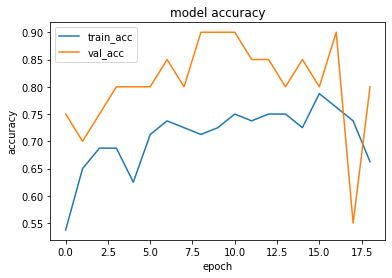

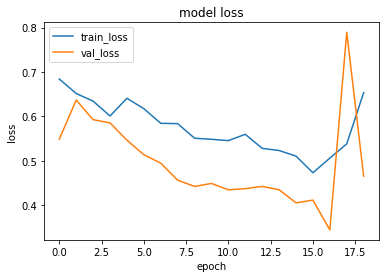

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.47507414]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.621801]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.6532046]]


1it [00:00, 13662.23it/s]


prediction for video control_1.mov is [[0.3070758]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.27232155]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.26231217]]


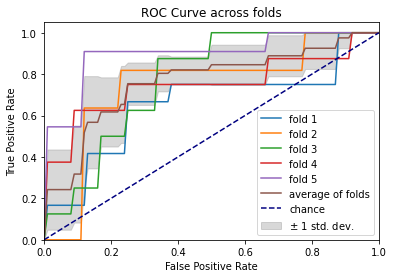

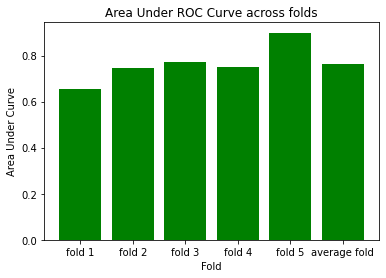

In [104]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6682 - accuracy: 0.6500 - precision_154: 0.6562 - recall_154: 0.5526 - val_loss: 0.7814 - val_accuracy: 0.5500 - val_precision_154: 0.5789 - val_recall_154: 0.9167
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6672 - accuracy: 0.6500 - precision_154: 0.5893 - recall_154: 0.8684 - val_loss: 0.6529 - val_accuracy: 0.5500 - val_precision_154: 0.7143 - val_recall_154: 0.4167
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6004 - accuracy: 0.7375 - precision_154: 0.7931 - recall_154: 0.6053 - val_loss: 0.6553 - val_accuracy: 0.6000 - val_precision_154: 0.6667 - val_recall_154: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5452 - accuracy: 0.7750 - precision_154: 0.7632 - recall_154: 0.7632 - val_loss: 0.8404 - val_accuracy: 0.6000 - val_precision_154: 0.6429 - val_recall_154: 0.7500
Epoch 5/75
3/3 [==============================] 

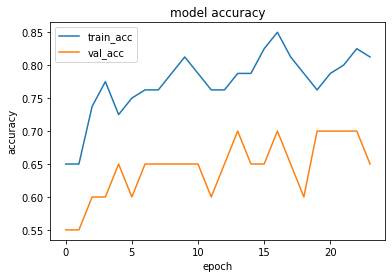

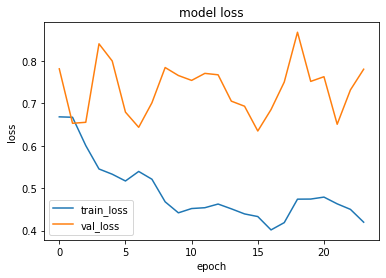

1it [00:00, 12192.74it/s]


prediction for video armflapping_1.mov is [[0.5086192]]


1it [00:00, 12372.58it/s]


prediction for video armflapping_3.mov is [[0.5525954]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.6470704]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.14210793]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.12123606]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.11580291]]
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6837 - accuracy: 0.5750 - precision_155: 0.5472 - recall_155: 0.7436 - val_loss: 0.6019 - val_accuracy: 0.7000 - val_precision_155: 0.7273 - val_recall_155: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6286 - accuracy: 0.7000 - precision_155: 0.6923 - recall_155: 0.6923 - val_loss: 0.6667 - val_accuracy: 0.6500 - val_precision_155: 0.8333 - val_recall_155: 0.4545
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6479 - accuracy: 0.6000 - precision_155: 0.7692 - recall_155: 0.2564 - val_loss: 0.5830 - val_accuracy: 0.7500 - val_precision_155: 0.8750 - val_recall_155: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.5668 - accuracy: 0.7375 - precision_155: 0.7500 - recall_155: 0.6923 - val_loss: 0.5161 - val_accuracy: 0.7500 - val_precision_155: 0.7500 - val_recall_155: 0.

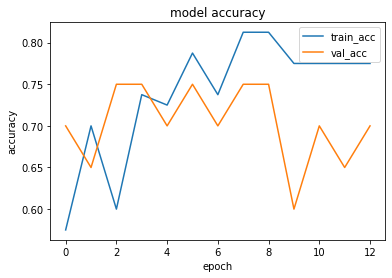

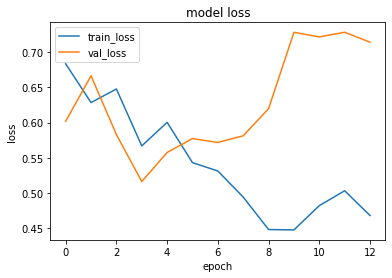

1it [00:00, 12787.51it/s]


prediction for video armflapping_1.mov is [[0.44254565]]


1it [00:00, 12865.96it/s]


prediction for video armflapping_3.mov is [[0.47087815]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.48035815]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.39099145]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.36184168]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.35535088]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6896 - accuracy: 0.5250 - precision_156: 0.5455 - recall_156: 0.5714 - val_loss: 0.6700 - val_accuracy: 0.6500 - val_precision_156: 0.5385 - val_recall_156: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6074 - accuracy: 0.6625 - precision_156: 0.6415 - recall_156: 0.8095 - val_loss: 0.6377 - val_accuracy: 0.8000 - val_precision_156: 0.7000 - val_recall_156: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5416 - accuracy: 0.7375 - precision_156: 0.7442 - recall_156: 0.7619 - val_loss: 0.6740 - val_accuracy: 0.7000 - val_precision_156: 0.6000 - val_recall_156: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 181ms/step - loss: 0.5443 - accuracy: 0.7625 - precision_156: 0.7949 - recall_156: 0.7381 - val_loss: 0.7076 - val_accuracy: 0.6000 - val_precision_156: 0.5000 - val_recall_156: 0.

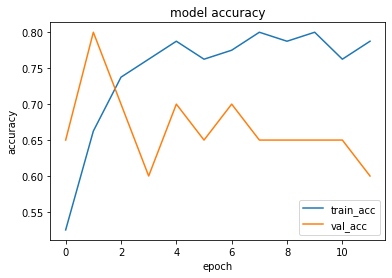

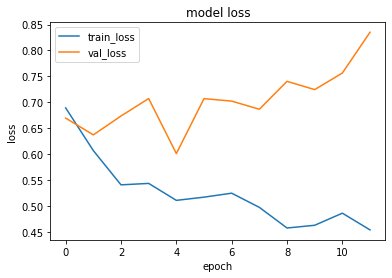

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.54930896]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.5741269]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.607269]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.5021975]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.48389274]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.46613508]]
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6990 - accuracy: 0.5625 - precision_157: 0.6000 - recall_157: 0.5000 - val_loss: 0.6575 - val_accuracy: 0.4000 - val_precision_157: 0.3889 - val_recall_157: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6295 - accuracy: 0.6125 - precision_157: 0.5753 - recall_157: 1.0000 - val_loss: 0.6550 - val_accuracy: 0.6500 - val_precision_157: 0.5556 - val_recall_157: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6378 - accuracy: 0.6625 - precision_157: 0.6316 - recall_157: 0.8571 - val_loss: 0.6160 - val_accuracy: 0.7500 - val_precision_157: 0.7143 - val_recall_157: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.5647 - accuracy: 0.7125 - precision_157: 0.7021 - recall_157: 0.7857 - val_loss: 0.5820 - val_accuracy: 0.8000 - val_precision_157: 0.8333 - val_recall_157: 0.

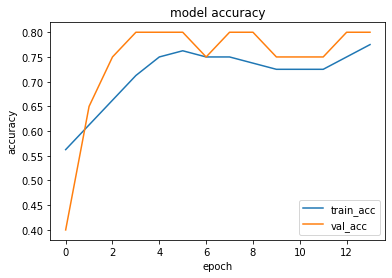

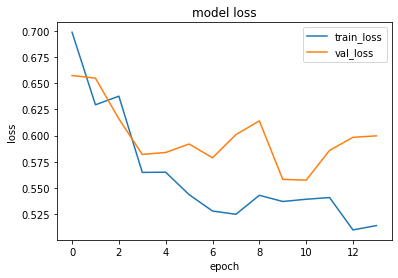

1it [00:00, 11848.32it/s]


prediction for video armflapping_1.mov is [[0.57391274]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.6876406]]


1it [00:00, 13189.64it/s]


prediction for video armflapping_2.mov is [[0.74293655]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.38277784]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.31981283]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.3109098]]
Epoch 1/75
3/3 [==============================] - 0s 171ms/step - loss: 0.6975 - accuracy: 0.4500 - precision_158: 0.4528 - recall_158: 0.6154 - val_loss: 0.6237 - val_accuracy: 0.8000 - val_precision_158: 0.8182 - val_recall_158: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6594 - accuracy: 0.6750 - precision_158: 0.6970 - recall_158: 0.5897 - val_loss: 0.5972 - val_accuracy: 0.8500 - val_precision_158: 0.9000 - val_recall_158: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6342 - accuracy: 0.6375 - precision_158: 0.6562 - recall_158: 0.5385 - val_loss: 0.5974 - val_accuracy: 0.6500 - val_precision_158: 0.6250 - val_recall_158: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6449 - accuracy: 0.7125 - precision_158: 0.6905 - recall_158: 0.7436 - val_loss: 0.5630 - val_accuracy: 0.7500 - val_precision_158: 0.8750 - val_recall_158: 0.6

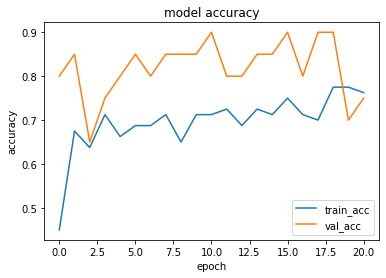

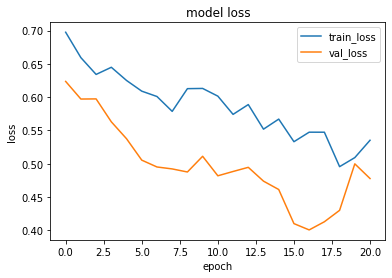

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.5328096]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.6116996]]


1it [00:00, 9915.61it/s]


prediction for video armflapping_2.mov is [[0.60909885]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.46412706]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.42641997]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.41108721]]


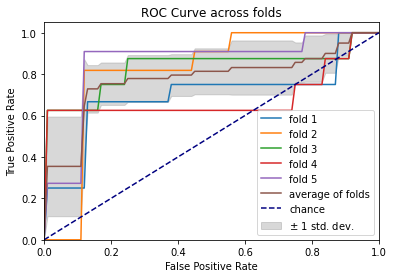

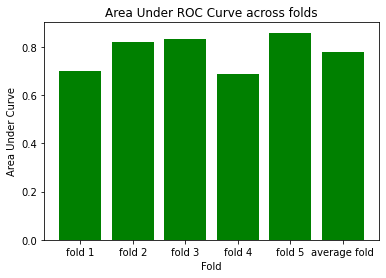

In [105]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6671 - accuracy: 0.5875 - precision_160: 0.5510 - recall_160: 0.7105 - val_loss: 0.7643 - val_accuracy: 0.5500 - val_precision_160: 0.6000 - val_recall_160: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6817 - accuracy: 0.6625 - precision_160: 0.6078 - recall_160: 0.8158 - val_loss: 0.7274 - val_accuracy: 0.4500 - val_precision_160: 0.6667 - val_recall_160: 0.1667
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6412 - accuracy: 0.6125 - precision_160: 0.7059 - recall_160: 0.3158 - val_loss: 0.6555 - val_accuracy: 0.5500 - val_precision_160: 0.6667 - val_recall_160: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.5884 - accuracy: 0.7000 - precision_160: 0.7500 - recall_160: 0.5526 - val_loss: 0.6912 - val_accuracy: 0.5500 - val_precision_160: 0.6154 - val_recall_160: 0.6667
Epoch 5/75
3/3 [==============================] 

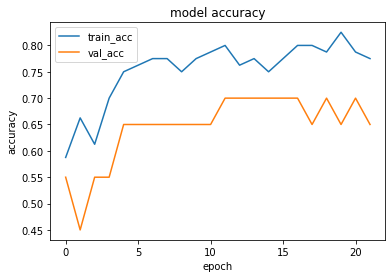

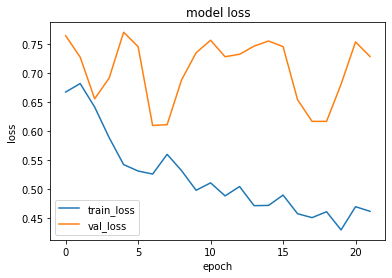

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.45487553]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.6047957]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.65975285]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.14249715]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.1186707]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.1177015]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6525 - accuracy: 0.6125 - precision_161: 0.5714 - recall_161: 0.8205 - val_loss: 0.6436 - val_accuracy: 0.7000 - val_precision_161: 0.6667 - val_recall_161: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.8577 - accuracy: 0.5375 - precision_161: 0.5385 - recall_161: 0.3590 - val_loss: 0.6162 - val_accuracy: 0.6000 - val_precision_161: 0.8000 - val_recall_161: 0.3636
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6232 - accuracy: 0.6875 - precision_161: 0.7188 - recall_161: 0.5897 - val_loss: 0.6041 - val_accuracy: 0.7500 - val_precision_161: 0.8000 - val_recall_161: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6311 - accuracy: 0.6750 - precision_161: 0.6667 - recall_161: 0.6667 - val_loss: 0.5990 - val_accuracy: 0.7500 - val_precision_161: 0.7500 - val_recall_161: 0.8

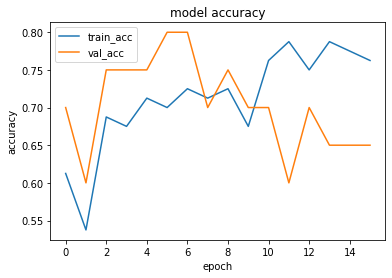

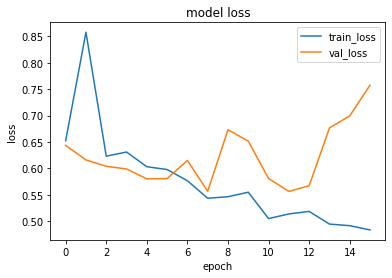

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.41697434]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.5230436]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.6026985]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.31782073]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.2729537]]


1it [00:00, 15768.06it/s]


prediction for video control_3.mov is [[0.25829118]]
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6733 - accuracy: 0.5375 - precision_162: 0.5410 - recall_162: 0.7857 - val_loss: 0.7002 - val_accuracy: 0.4500 - val_precision_162: 0.4211 - val_recall_162: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6129 - accuracy: 0.6125 - precision_162: 0.5821 - recall_162: 0.9286 - val_loss: 0.6372 - val_accuracy: 0.7000 - val_precision_162: 0.6250 - val_recall_162: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 160ms/step - loss: 0.5688 - accuracy: 0.7625 - precision_162: 0.8286 - recall_162: 0.6905 - val_loss: 0.6994 - val_accuracy: 0.6500 - val_precision_162: 0.5455 - val_recall_162: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.5659 - accuracy: 0.7500 - precision_162: 0.7750 - recall_162: 0.7381 - val_loss: 0.6963 - val_accuracy: 0.6500 - val_precision_162: 0.5455 - val_recall_162: 0.

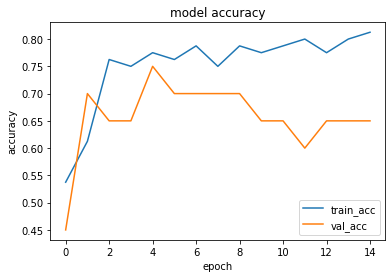

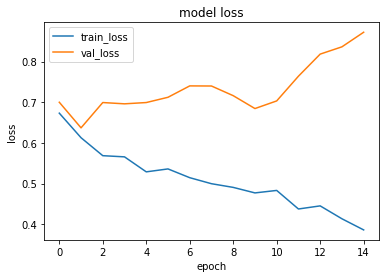

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.57822996]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.8676392]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.7690296]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.4372327]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.3217005]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.33634555]]
Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6896 - accuracy: 0.5125 - precision_163: 0.5273 - recall_163: 0.6905 - val_loss: 0.6996 - val_accuracy: 0.4000 - val_precision_163: 0.3333 - val_recall_163: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6493 - accuracy: 0.6375 - precision_163: 0.6327 - recall_163: 0.7381 - val_loss: 0.6269 - val_accuracy: 0.7000 - val_precision_163: 0.6250 - val_recall_163: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6089 - accuracy: 0.7000 - precision_163: 0.6667 - recall_163: 0.8571 - val_loss: 0.5833 - val_accuracy: 0.8000 - val_precision_163: 0.8333 - val_recall_163: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5834 - accuracy: 0.7125 - precision_163: 0.7714 - recall_163: 0.6429 - val_loss: 0.6688 - val_accuracy: 0.7000 - val_precision_163: 0.7500 - val_recall_163: 0.

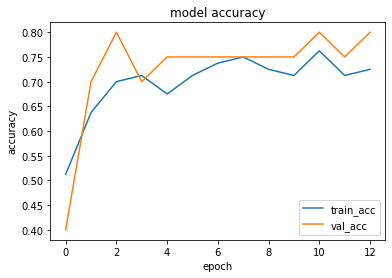

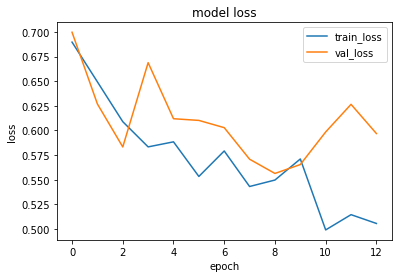

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.5844262]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.6139474]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_2.mov is [[0.7938113]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.4063231]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.34697187]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.336394]]
Epoch 1/75
3/3 [==============================] - 1s 201ms/step - loss: 0.7087 - accuracy: 0.5375 - precision_164: 0.5333 - recall_164: 0.4103 - val_loss: 0.6709 - val_accuracy: 0.6500 - val_precision_164: 0.6250 - val_recall_164: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6859 - accuracy: 0.6250 - precision_164: 0.5957 - recall_164: 0.7179 - val_loss: 0.6305 - val_accuracy: 0.8000 - val_precision_164: 0.7692 - val_recall_164: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6564 - accuracy: 0.6750 - precision_164: 0.6667 - recall_164: 0.6667 - val_loss: 0.5835 - val_accuracy: 0.8000 - val_precision_164: 0.7692 - val_recall_164: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6088 - accuracy: 0.6375 - precision_164: 0.6000 - recall_164: 0.7692 - val_loss: 0.5743 - val_accuracy: 0.8000 - val_precision_164: 0.7692 - val_recall_164: 0.90

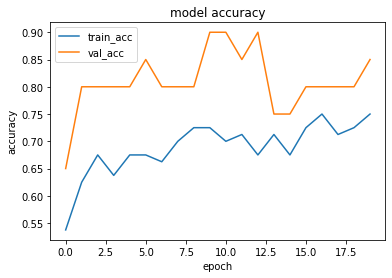

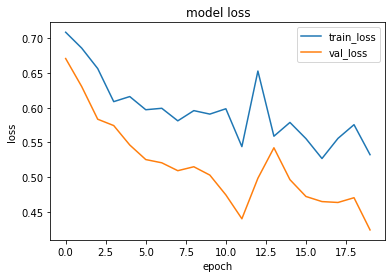

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.53648484]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.4913269]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.57213926]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.4736193]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.4201548]]


1it [00:00, 13842.59it/s]


prediction for video control_3.mov is [[0.42915693]]


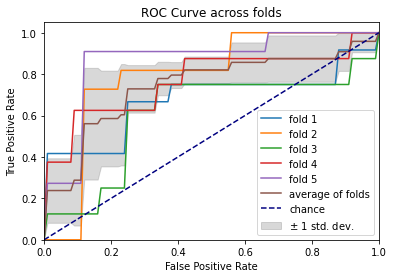

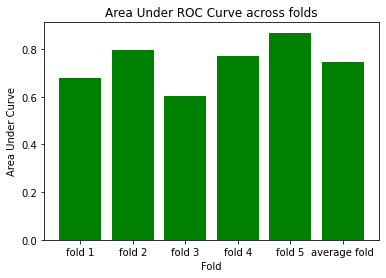

In [106]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.7291 - accuracy: 0.4375 - precision_166: 0.4103 - recall_166: 0.4211 - val_loss: 0.6860 - val_accuracy: 0.6000 - val_precision_166: 0.6000 - val_recall_166: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 184ms/step - loss: 0.6459 - accuracy: 0.6125 - precision_166: 0.5522 - recall_166: 0.9737 - val_loss: 0.6980 - val_accuracy: 0.5500 - val_precision_166: 0.6000 - val_recall_166: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6298 - accuracy: 0.7000 - precision_166: 0.6346 - recall_166: 0.8684 - val_loss: 0.6763 - val_accuracy: 0.5500 - val_precision_166: 0.6364 - val_recall_166: 0.5833
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.5944 - accuracy: 0.6875 - precision_166: 0.8095 - recall_166: 0.4474 - val_loss: 0.6633 - val_accuracy: 0.6000 - val_precision_166: 0.7500 - val_recall_166: 0.5000
Epoch 5/75
3/3 [==============================] 

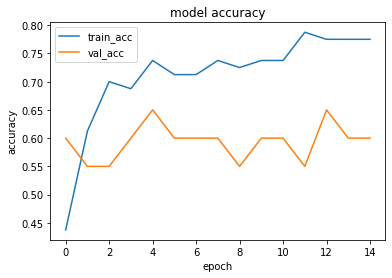

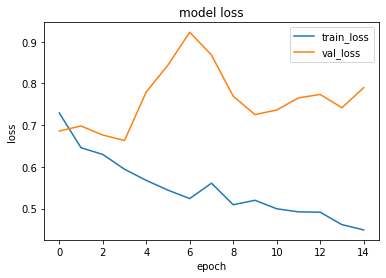

1it [00:00, 13486.51it/s]


prediction for video armflapping_1.mov is [[0.4216172]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.49775726]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.60924125]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.12501988]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.11519676]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.14391765]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7341 - accuracy: 0.5250 - precision_167: 0.5106 - recall_167: 0.6154 - val_loss: 0.6596 - val_accuracy: 0.5500 - val_precision_167: 0.7500 - val_recall_167: 0.2727
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6580 - accuracy: 0.6625 - precision_167: 0.7143 - recall_167: 0.5128 - val_loss: 0.6281 - val_accuracy: 0.7500 - val_precision_167: 0.7500 - val_recall_167: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6305 - accuracy: 0.7000 - precision_167: 0.6667 - recall_167: 0.7692 - val_loss: 0.5755 - val_accuracy: 0.7500 - val_precision_167: 0.6875 - val_recall_167: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5834 - accuracy: 0.6750 - precision_167: 0.6444 - recall_167: 0.7436 - val_loss: 0.5863 - val_accuracy: 0.7000 - val_precision_167: 0.6667 - val_recall_167: 0.

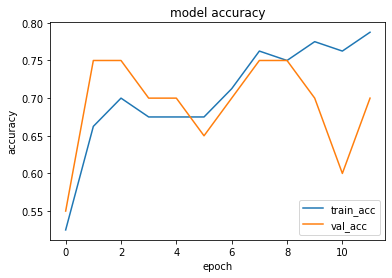

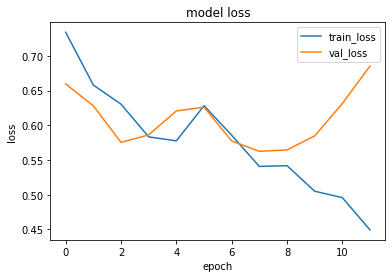

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.4933808]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.54418373]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.5322025]]


1it [00:00, 14768.68it/s]


prediction for video control_1.mov is [[0.4709896]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.4628937]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.4573367]]
Epoch 1/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6762 - accuracy: 0.5375 - precision_168: 0.5385 - recall_168: 0.8333 - val_loss: 0.7017 - val_accuracy: 0.5500 - val_precision_168: 0.0000e+00 - val_recall_168: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6478 - accuracy: 0.6125 - precision_168: 0.6774 - recall_168: 0.5000 - val_loss: 0.6889 - val_accuracy: 0.6500 - val_precision_168: 0.5333 - val_recall_168: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6238 - accuracy: 0.6375 - precision_168: 0.6140 - recall_168: 0.8333 - val_loss: 0.6765 - val_accuracy: 0.6500 - val_precision_168: 0.5385 - val_recall_168: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5690 - accuracy: 0.7500 - precision_168: 0.7619 - recall_168: 0.7619 - val_loss: 0.6245 - val_accuracy: 0.7000 - val_precision_168: 0.6000 - val_recall_

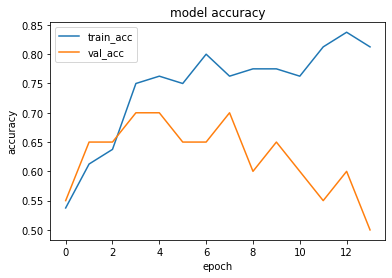

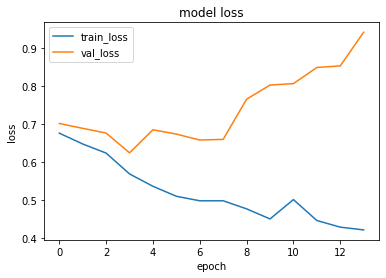

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.5582947]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.8299732]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.80695933]]


1it [00:00, 14122.24it/s]


prediction for video control_1.mov is [[0.5379776]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.23023659]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.54906404]]
Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6765 - accuracy: 0.5500 - precision_169: 0.5577 - recall_169: 0.6905 - val_loss: 0.6679 - val_accuracy: 0.4000 - val_precision_169: 0.3889 - val_recall_169: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 119ms/step - loss: 0.6170 - accuracy: 0.5875 - precision_169: 0.5652 - recall_169: 0.9286 - val_loss: 0.6713 - val_accuracy: 0.7000 - val_precision_169: 1.0000 - val_recall_169: 0.2500
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6093 - accuracy: 0.7000 - precision_169: 0.6875 - recall_169: 0.7857 - val_loss: 0.6211 - val_accuracy: 0.7000 - val_precision_169: 0.6250 - val_recall_169: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6035 - accuracy: 0.7250 - precision_169: 0.6923 - recall_169: 0.8571 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_169: 0.6250 - val_recall_169: 0.

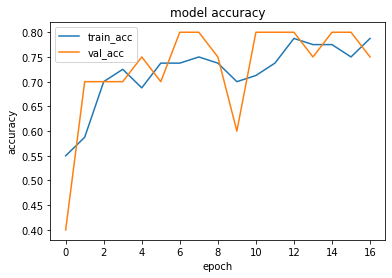

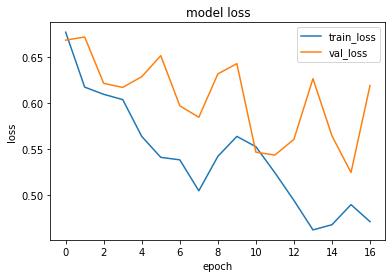

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.46672958]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.48176488]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.6534057]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.40320763]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.30598336]]


1it [00:00, 11915.64it/s]


prediction for video control_3.mov is [[0.3662392]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6817 - accuracy: 0.5500 - precision_170: 0.5231 - recall_170: 0.8718 - val_loss: 0.6740 - val_accuracy: 0.4500 - val_precision_170: 0.0000e+00 - val_recall_170: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6626 - accuracy: 0.6250 - precision_170: 0.7368 - recall_170: 0.3590 - val_loss: 0.5556 - val_accuracy: 0.7500 - val_precision_170: 0.7143 - val_recall_170: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6257 - accuracy: 0.6750 - precision_170: 0.6327 - recall_170: 0.7949 - val_loss: 0.5046 - val_accuracy: 0.8500 - val_precision_170: 0.8333 - val_recall_170: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6154 - accuracy: 0.6625 - precision_170: 0.6667 - recall_170: 0.6154 - val_loss: 0.4882 - val_accuracy: 0.9000 - val_precision_170: 0.9091 - val_recall_

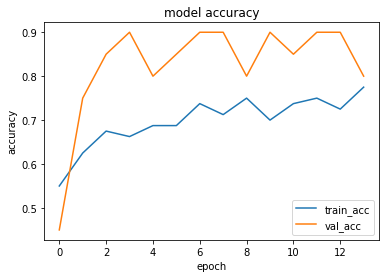

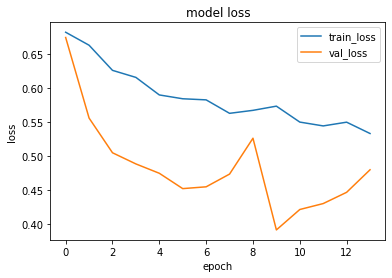

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.4381026]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.45887828]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.52483547]]


1it [00:00, 2657.99it/s]


prediction for video control_1.mov is [[0.3688661]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.34064993]]


1it [00:00, 15650.39it/s]

prediction for video control_3.mov is [[0.32516652]]


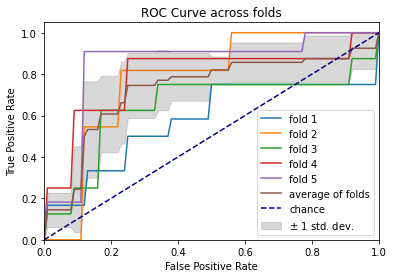

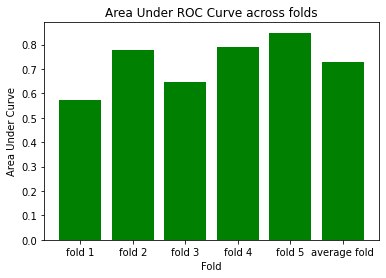

In [107]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7261 - accuracy: 0.4500 - precision_172: 0.4531 - recall_172: 0.7632 - val_loss: 0.6820 - val_accuracy: 0.6000 - val_precision_172: 0.8333 - val_recall_172: 0.4167
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6626 - accuracy: 0.5875 - precision_172: 0.6667 - recall_172: 0.2632 - val_loss: 0.6851 - val_accuracy: 0.6000 - val_precision_172: 0.6429 - val_recall_172: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6038 - accuracy: 0.7250 - precision_172: 0.6600 - recall_172: 0.8684 - val_loss: 0.8022 - val_accuracy: 0.5500 - val_precision_172: 0.6000 - val_recall_172: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5609 - accuracy: 0.7125 - precision_172: 0.6531 - recall_172: 0.8421 - val_loss: 0.8452 - val_accuracy: 0.5500 - val_precision_172: 0.6364 - val_recall_172: 0.5833
Epoch 5/75
3/3 [==============================] 

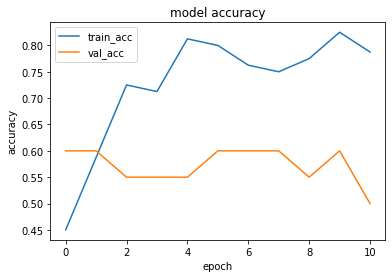

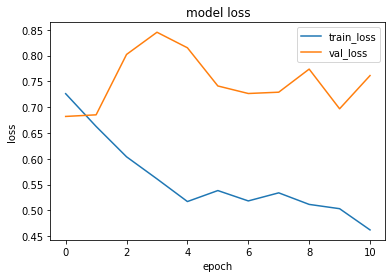

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4995697]]


1it [00:00, 12520.31it/s]


prediction for video armflapping_3.mov is [[0.4823297]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.50223863]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.49237034]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.4872673]]


1it [00:00, 15768.06it/s]


prediction for video control_3.mov is [[0.4890524]]
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6914 - accuracy: 0.4750 - precision_173: 0.4681 - recall_173: 0.5641 - val_loss: 0.6001 - val_accuracy: 0.7000 - val_precision_173: 0.6667 - val_recall_173: 0.9091
Epoch 2/75
3/3 [==============================] - 1s 202ms/step - loss: 0.6360 - accuracy: 0.6625 - precision_173: 0.6579 - recall_173: 0.6410 - val_loss: 0.5840 - val_accuracy: 0.7500 - val_precision_173: 0.7143 - val_recall_173: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6024 - accuracy: 0.6875 - precision_173: 0.6750 - recall_173: 0.6923 - val_loss: 0.6058 - val_accuracy: 0.7500 - val_precision_173: 0.8750 - val_recall_173: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5638 - accuracy: 0.7125 - precision_173: 0.7105 - recall_173: 0.6923 - val_loss: 0.5713 - val_accuracy: 0.7000 - val_precision_173: 0.7273 - val_recall_173: 0.7

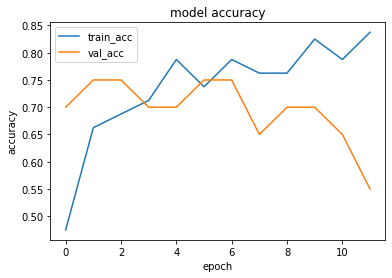

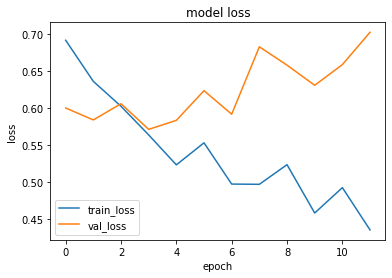

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.5086931]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.57801664]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.6526796]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.43659025]]


1it [00:00, 11491.24it/s]


prediction for video control_2.mov is [[0.41131285]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.4001173]]
Epoch 1/75
3/3 [==============================] - 0s 173ms/step - loss: 0.7051 - accuracy: 0.4250 - precision_174: 0.4286 - recall_174: 0.2857 - val_loss: 0.6813 - val_accuracy: 0.4000 - val_precision_174: 0.3889 - val_recall_174: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6115 - accuracy: 0.6500 - precision_174: 0.6061 - recall_174: 0.9524 - val_loss: 0.6225 - val_accuracy: 0.8000 - val_precision_174: 0.7000 - val_recall_174: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 144ms/step - loss: 0.5897 - accuracy: 0.7250 - precision_174: 0.7632 - recall_174: 0.6905 - val_loss: 0.6877 - val_accuracy: 0.7000 - val_precision_174: 0.5833 - val_recall_174: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6321 - accuracy: 0.7000 - precision_174: 0.6731 - recall_174: 0.8333 - val_loss: 0.6993 - val_accuracy: 0.7000 - val_precision_174: 0.5833 - val_recall_174: 0.8

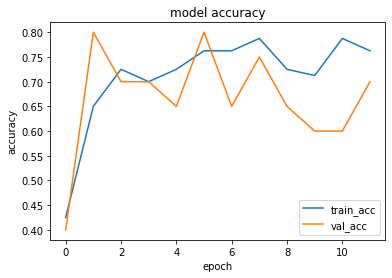

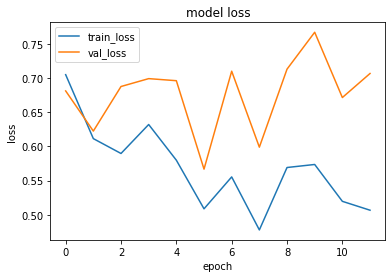

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.52030355]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.5501637]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.58688337]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.4840642]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.46891364]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.46448526]]
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.7120 - accuracy: 0.4500 - precision_175: 0.4375 - recall_175: 0.1667 - val_loss: 0.6649 - val_accuracy: 0.4000 - val_precision_175: 0.3889 - val_recall_175: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6464 - accuracy: 0.5875 - precision_175: 0.5600 - recall_175: 1.0000 - val_loss: 0.6788 - val_accuracy: 0.4500 - val_precision_175: 0.4118 - val_recall_175: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6083 - accuracy: 0.6375 - precision_175: 0.6032 - recall_175: 0.9048 - val_loss: 0.6870 - val_accuracy: 0.7000 - val_precision_175: 0.7500 - val_recall_175: 0.3750
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6104 - accuracy: 0.7125 - precision_175: 0.7111 - recall_175: 0.7619 - val_loss: 0.6142 - val_accuracy: 0.8000 - val_precision_175: 0.8333 - val_recall_175: 0.

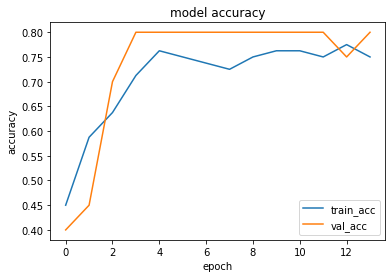

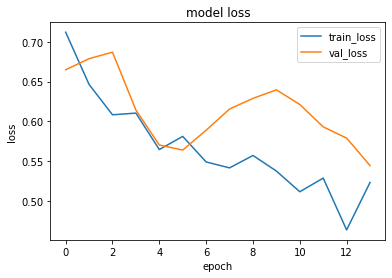

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.46421888]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.43766087]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.70279187]]


1it [00:00, 12483.05it/s]


prediction for video control_1.mov is [[0.31517684]]


1it [00:00, 13486.51it/s]


prediction for video control_2.mov is [[0.26314658]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.258325]]
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.7349 - accuracy: 0.5500 - precision_176: 0.5789 - recall_176: 0.2821 - val_loss: 0.6755 - val_accuracy: 0.6500 - val_precision_176: 0.6250 - val_recall_176: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6707 - accuracy: 0.5875 - precision_176: 0.5429 - recall_176: 0.9744 - val_loss: 0.6476 - val_accuracy: 0.6500 - val_precision_176: 0.6250 - val_recall_176: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6572 - accuracy: 0.6750 - precision_176: 0.6140 - recall_176: 0.8974 - val_loss: 0.5898 - val_accuracy: 0.8000 - val_precision_176: 0.7692 - val_recall_176: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6304 - accuracy: 0.6500 - precision_176: 0.7037 - recall_176: 0.4872 - val_loss: 0.6029 - val_accuracy: 0.6500 - val_precision_176: 0.7500 - val_recall_176: 0.54

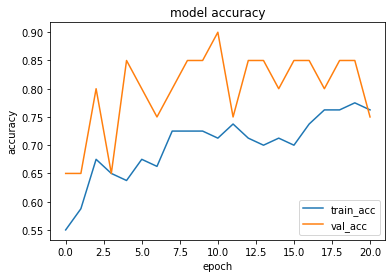

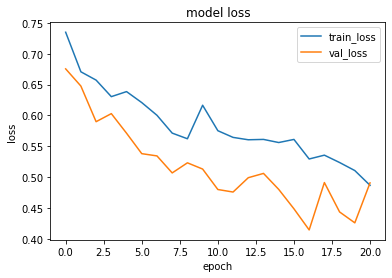

1it [00:00, 11366.68it/s]


prediction for video armflapping_1.mov is [[0.52028036]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5186598]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.6289481]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.3383696]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.26833704]]


1it [00:00, 18477.11it/s]

prediction for video control_3.mov is [[0.24581623]]


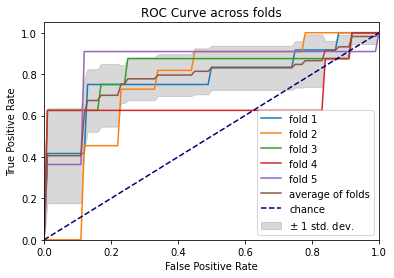

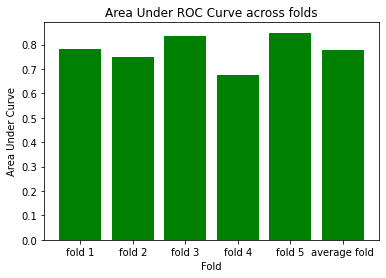

In [108]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7126 - accuracy: 0.5375 - precision_178: 0.5200 - recall_178: 0.3421 - val_loss: 0.6812 - val_accuracy: 0.6000 - val_precision_178: 0.7000 - val_recall_178: 0.5833
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6350 - accuracy: 0.7000 - precision_178: 0.6591 - recall_178: 0.7632 - val_loss: 0.6741 - val_accuracy: 0.6000 - val_precision_178: 0.6429 - val_recall_178: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.5880 - accuracy: 0.7500 - precision_178: 0.7500 - recall_178: 0.7105 - val_loss: 0.8360 - val_accuracy: 0.6500 - val_precision_178: 0.6923 - val_recall_178: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5782 - accuracy: 0.7000 - precision_178: 0.6667 - recall_178: 0.7368 - val_loss: 0.7124 - val_accuracy: 0.5500 - val_precision_178: 0.6154 - val_recall_178: 0.6667
Epoch 5/75
3/3 [==============================] 

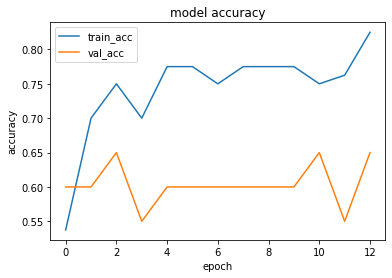

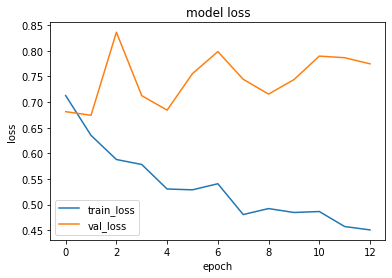

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.12896144]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5126095]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.3803465]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.11058831]]


1it [00:00, 13934.56it/s]


prediction for video control_2.mov is [[0.10545462]]


1it [00:00, 12671.61it/s]


prediction for video control_3.mov is [[0.10657644]]
Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.7017 - accuracy: 0.5125 - precision_179: 0.5000 - recall_179: 0.7436 - val_loss: 0.6358 - val_accuracy: 0.7000 - val_precision_179: 0.7778 - val_recall_179: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6265 - accuracy: 0.7375 - precision_179: 0.7368 - recall_179: 0.7179 - val_loss: 0.6092 - val_accuracy: 0.7000 - val_precision_179: 0.6471 - val_recall_179: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6333 - accuracy: 0.6375 - precision_179: 0.5926 - recall_179: 0.8205 - val_loss: 0.6261 - val_accuracy: 0.6500 - val_precision_179: 0.8333 - val_recall_179: 0.4545
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.7087 - accuracy: 0.6625 - precision_179: 0.9286 - recall_179: 0.3333 - val_loss: 0.5948 - val_accuracy: 0.7500 - val_precision_179: 0.8750 - val_recall_179: 0.

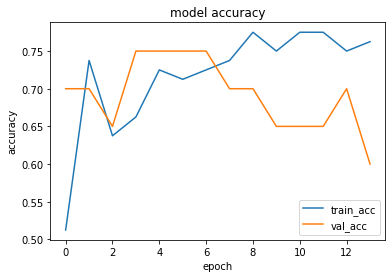

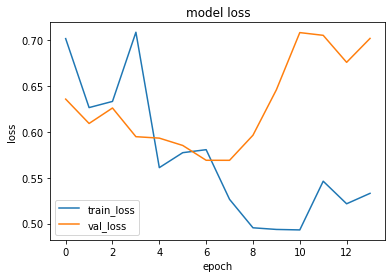

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.4441638]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.50626904]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.5198409]]


1it [00:00, 11008.67it/s]


prediction for video control_1.mov is [[0.38932204]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.35806966]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.35171402]]
Epoch 1/75
3/3 [==============================] - 1s 130ms/step - loss: 0.6957 - accuracy: 0.5875 - precision_180: 0.5738 - recall_180: 0.8333 - val_loss: 0.6945 - val_accuracy: 0.4000 - val_precision_180: 0.3889 - val_recall_180: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6023 - accuracy: 0.5875 - precision_180: 0.5652 - recall_180: 0.9286 - val_loss: 0.7390 - val_accuracy: 0.6500 - val_precision_180: 0.5385 - val_recall_180: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6929 - accuracy: 0.7000 - precision_180: 0.7500 - recall_180: 0.6429 - val_loss: 0.5989 - val_accuracy: 0.7500 - val_precision_180: 0.6364 - val_recall_180: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6047 - accuracy: 0.7000 - precision_180: 0.7812 - recall_180: 0.5952 - val_loss: 0.7166 - val_accuracy: 0.5500 - val_precision_180: 0.4444 - val_recall_180: 0.

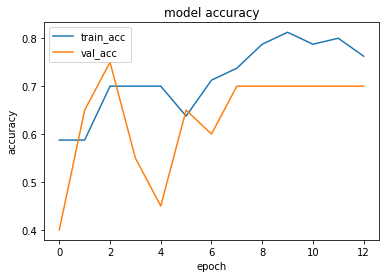

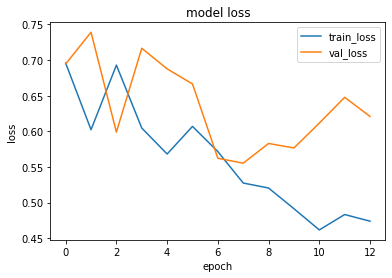

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.40963215]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.7462598]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_2.mov is [[0.7540395]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.3908898]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.3556128]]


1it [00:00, 9446.63it/s]


prediction for video control_3.mov is [[0.3611688]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6918 - accuracy: 0.5500 - precision_181: 0.5405 - recall_181: 0.9524 - val_loss: 0.7477 - val_accuracy: 0.6000 - val_precision_181: 0.0000e+00 - val_recall_181: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.7000 - accuracy: 0.5625 - precision_181: 0.6129 - recall_181: 0.4524 - val_loss: 0.6813 - val_accuracy: 0.4500 - val_precision_181: 0.4118 - val_recall_181: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6289 - accuracy: 0.6250 - precision_181: 0.5833 - recall_181: 1.0000 - val_loss: 0.6558 - val_accuracy: 0.6500 - val_precision_181: 0.5556 - val_recall_181: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5774 - accuracy: 0.7250 - precision_181: 0.7000 - recall_181: 0.8333 - val_loss: 0.6337 - val_accuracy: 0.8000 - val_precision_181: 0.8333 - val_recall_

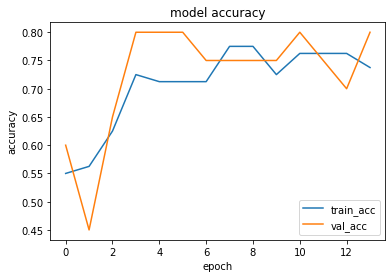

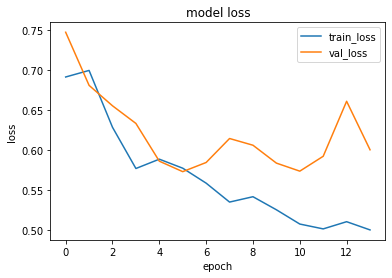

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5082787]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.47934288]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.55790055]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.47674194]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.4410743]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.45319468]]
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6782 - accuracy: 0.6750 - precision_182: 0.6275 - recall_182: 0.8205 - val_loss: 0.5501 - val_accuracy: 0.8500 - val_precision_182: 0.9000 - val_recall_182: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6294 - accuracy: 0.6750 - precision_182: 0.6383 - recall_182: 0.7692 - val_loss: 0.5340 - val_accuracy: 0.7500 - val_precision_182: 0.7500 - val_recall_182: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6126 - accuracy: 0.6500 - precision_182: 0.7037 - recall_182: 0.4872 - val_loss: 0.6093 - val_accuracy: 0.7000 - val_precision_182: 0.7273 - val_recall_182: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 215ms/step - loss: 0.6217 - accuracy: 0.6375 - precision_182: 0.6786 - recall_182: 0.4872 - val_loss: 0.5368 - val_accuracy: 0.7500 - val_precision_182: 0.7500 - val_recall_182: 0.

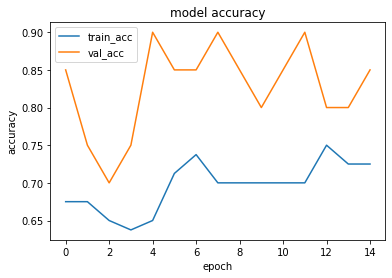

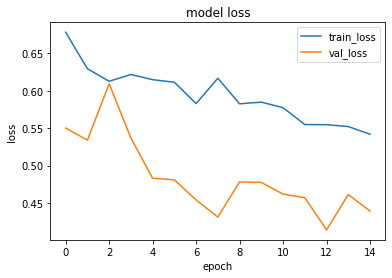

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.4715049]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5248408]]


1it [00:00, 11397.57it/s]


prediction for video armflapping_2.mov is [[0.5127572]]


1it [00:00, 14027.77it/s]


prediction for video control_1.mov is [[0.43459475]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.41363108]]


1it [00:00, 15196.75it/s]


prediction for video control_3.mov is [[0.40845096]]


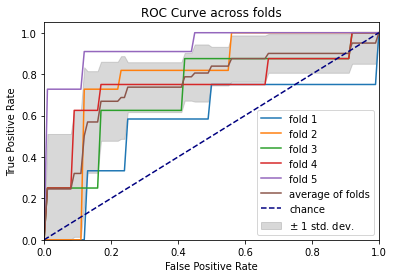

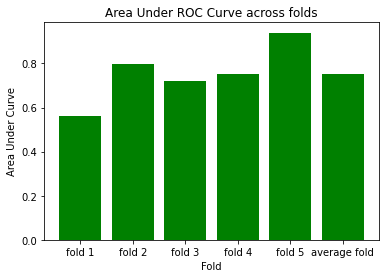

In [109]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 165ms/step - loss: 0.7620 - accuracy: 0.3875 - precision_184: 0.4068 - recall_184: 0.6316 - val_loss: 0.6731 - val_accuracy: 0.5500 - val_precision_184: 0.5789 - val_recall_184: 0.9167
Epoch 2/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6482 - accuracy: 0.7000 - precision_184: 0.6667 - recall_184: 0.7368 - val_loss: 0.6285 - val_accuracy: 0.7000 - val_precision_184: 0.6875 - val_recall_184: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6072 - accuracy: 0.6250 - precision_184: 0.5690 - recall_184: 0.8684 - val_loss: 0.6035 - val_accuracy: 0.6500 - val_precision_184: 0.7273 - val_recall_184: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.5877 - accuracy: 0.8125 - precision_184: 0.8286 - recall_184: 0.7632 - val_loss: 0.7529 - val_accuracy: 0.5500 - val_precision_184: 0.6364 - val_recall_184: 0.5833
Epoch 5/75
3/3 [==============================] 

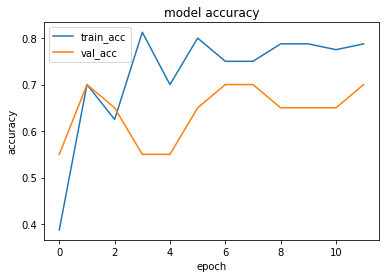

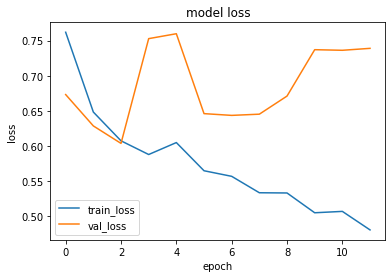

1it [00:00, 13934.56it/s]


prediction for video armflapping_1.mov is [[0.5343063]]


1it [00:00, 21399.51it/s]


prediction for video armflapping_3.mov is [[0.55834776]]


1it [00:00, 11125.47it/s]


prediction for video armflapping_2.mov is [[0.5680187]]


1it [00:00, 2493.64it/s]


prediction for video control_1.mov is [[0.5127054]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.50728416]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.5019408]]
Epoch 1/75
3/3 [==============================] - 1s 184ms/step - loss: 0.6765 - accuracy: 0.6000 - precision_185: 0.6000 - recall_185: 0.5385 - val_loss: 0.5936 - val_accuracy: 0.7000 - val_precision_185: 0.6667 - val_recall_185: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 171ms/step - loss: 0.6356 - accuracy: 0.7125 - precision_185: 0.7353 - recall_185: 0.6410 - val_loss: 0.5917 - val_accuracy: 0.7000 - val_precision_185: 0.8571 - val_recall_185: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 222ms/step - loss: 0.5660 - accuracy: 0.7250 - precision_185: 0.7576 - recall_185: 0.6410 - val_loss: 0.5746 - val_accuracy: 0.7000 - val_precision_185: 0.6923 - val_recall_185: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6355 - accuracy: 0.7125 - precision_185: 0.6818 - recall_185: 0.7692 - val_loss: 0.5567 - val_accuracy: 0.7500 - val_precision_185: 0.7500 - val_recall_185: 0.8

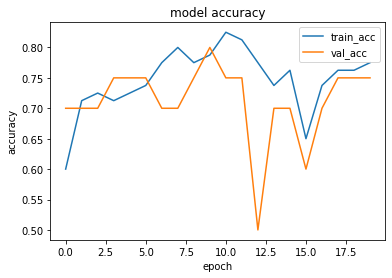

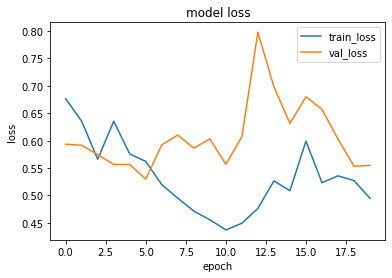

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.41563827]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.51446164]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.62996686]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.27504444]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.24194005]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.22498256]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6657 - accuracy: 0.5500 - precision_186: 0.5577 - recall_186: 0.6905 - val_loss: 0.7283 - val_accuracy: 0.4500 - val_precision_186: 0.4211 - val_recall_186: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6412 - accuracy: 0.5875 - precision_186: 0.5692 - recall_186: 0.8810 - val_loss: 0.6734 - val_accuracy: 0.4000 - val_precision_186: 0.3889 - val_recall_186: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6226 - accuracy: 0.6125 - precision_186: 0.5821 - recall_186: 0.9286 - val_loss: 0.6850 - val_accuracy: 0.7500 - val_precision_186: 0.6154 - val_recall_186: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.5863 - accuracy: 0.6875 - precision_186: 0.6667 - recall_186: 0.8095 - val_loss: 0.6524 - val_accuracy: 0.7000 - val_precision_186: 0.6250 - val_recall_186: 0.

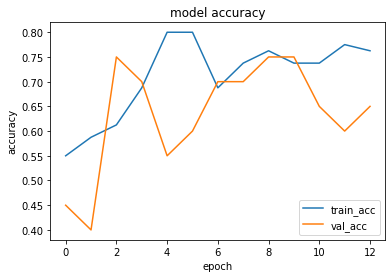

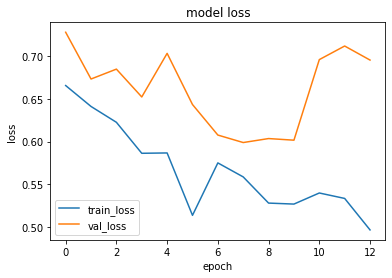

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.49779555]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.7158418]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.51162934]]


1it [00:00, 16644.06it/s]


prediction for video control_1.mov is [[0.4600782]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.44743046]]


1it [00:00, 12826.62it/s]


prediction for video control_3.mov is [[0.4416351]]
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7275 - accuracy: 0.4750 - precision_187: 0.5000 - recall_187: 0.1905 - val_loss: 0.6849 - val_accuracy: 0.4000 - val_precision_187: 0.3889 - val_recall_187: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6520 - accuracy: 0.5375 - precision_187: 0.5397 - recall_187: 0.8095 - val_loss: 0.6798 - val_accuracy: 0.4500 - val_precision_187: 0.4118 - val_recall_187: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6000 - accuracy: 0.6125 - precision_187: 0.5797 - recall_187: 0.9524 - val_loss: 0.6557 - val_accuracy: 0.7500 - val_precision_187: 0.7143 - val_recall_187: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5927 - accuracy: 0.7750 - precision_187: 0.7727 - recall_187: 0.8095 - val_loss: 0.6490 - val_accuracy: 0.7500 - val_precision_187: 0.7143 - val_recall_187: 0.6

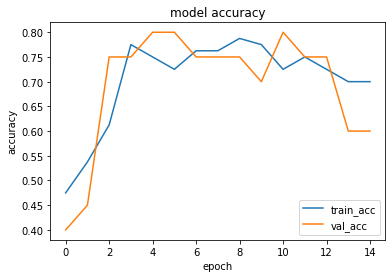

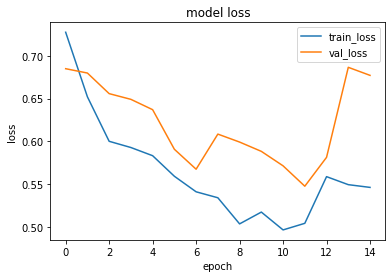

1it [00:00, 6668.21it/s]


prediction for video armflapping_1.mov is [[0.702837]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_3.mov is [[0.8110043]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.76061493]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.32533917]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.17239049]]


1it [00:00, 12192.74it/s]


prediction for video control_3.mov is [[0.41319904]]
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6847 - accuracy: 0.4750 - precision_188: 0.4286 - recall_188: 0.2308 - val_loss: 0.6710 - val_accuracy: 0.5500 - val_precision_188: 0.5500 - val_recall_188: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6670 - accuracy: 0.5250 - precision_188: 0.5088 - recall_188: 0.7436 - val_loss: 0.5676 - val_accuracy: 0.8000 - val_precision_188: 0.7692 - val_recall_188: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6232 - accuracy: 0.6750 - precision_188: 0.6585 - recall_188: 0.6923 - val_loss: 0.5080 - val_accuracy: 0.8000 - val_precision_188: 0.7692 - val_recall_188: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6200 - accuracy: 0.7125 - precision_188: 0.7000 - recall_188: 0.7179 - val_loss: 0.4599 - val_accuracy: 0.8000 - val_precision_188: 0.7692 - val_recall_188: 0.

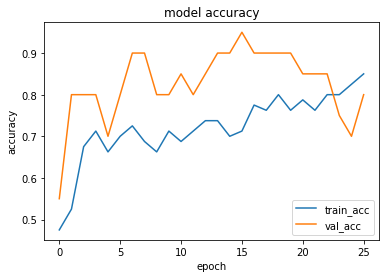

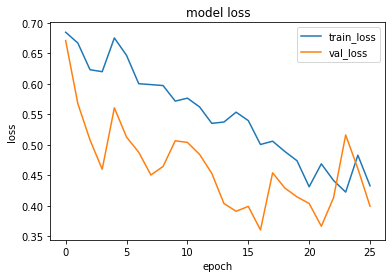

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.47097367]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5083949]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.5699988]]


1it [00:00, 12985.46it/s]


prediction for video control_1.mov is [[0.27768382]]


1it [00:00, 9000.65it/s]


prediction for video control_2.mov is [[0.26815507]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.23054725]]


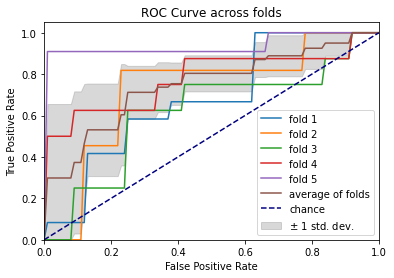

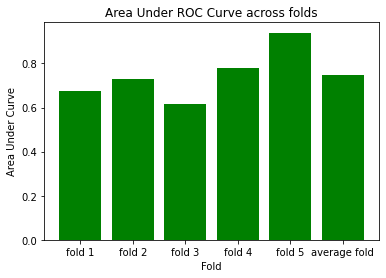

In [110]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6492 - accuracy: 0.6750 - precision_190: 0.6364 - recall_190: 0.7368 - val_loss: 0.9234 - val_accuracy: 0.4000 - val_precision_190: 0.0000e+00 - val_recall_190: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 193ms/step - loss: 0.7190 - accuracy: 0.6125 - precision_190: 0.8182 - recall_190: 0.2368 - val_loss: 0.6817 - val_accuracy: 0.6000 - val_precision_190: 0.6667 - val_recall_190: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5975 - accuracy: 0.7750 - precision_190: 0.7632 - recall_190: 0.7632 - val_loss: 0.7597 - val_accuracy: 0.6000 - val_precision_190: 0.6429 - val_recall_190: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5935 - accuracy: 0.7125 - precision_190: 0.6667 - recall_190: 0.7895 - val_loss: 0.8650 - val_accuracy: 0.6000 - val_precision_190: 0.6429 - val_recall_190: 0.7500
Epoch 5/75
3/3 [========================

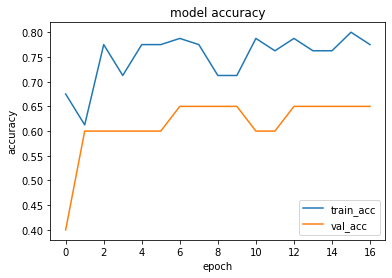

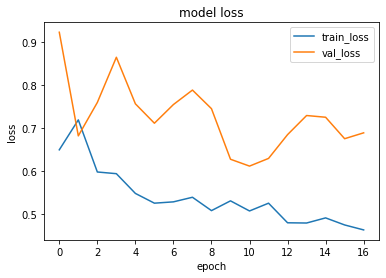

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.23993987]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.55328894]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.61645985]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.14985207]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.13521597]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.13702768]]
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6894 - accuracy: 0.5250 - precision_191: 0.5116 - recall_191: 0.5641 - val_loss: 0.6110 - val_accuracy: 0.7000 - val_precision_191: 0.6923 - val_recall_191: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6349 - accuracy: 0.7625 - precision_191: 0.7941 - recall_191: 0.6923 - val_loss: 0.8906 - val_accuracy: 0.5000 - val_precision_191: 1.0000 - val_recall_191: 0.0909
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7288 - accuracy: 0.5500 - precision_191: 0.6667 - recall_191: 0.1538 - val_loss: 0.6613 - val_accuracy: 0.5500 - val_precision_191: 0.5500 - val_recall_191: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.7114 - accuracy: 0.5000 - precision_191: 0.4935 - recall_191: 0.9744 - val_loss: 0.6591 - val_accuracy: 0.5500 - val_precision_191: 0.5500 - val_recall_191: 1.

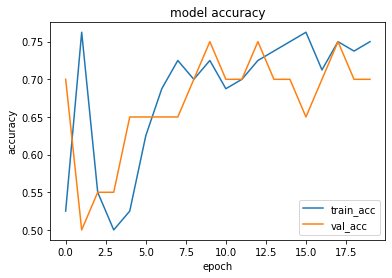

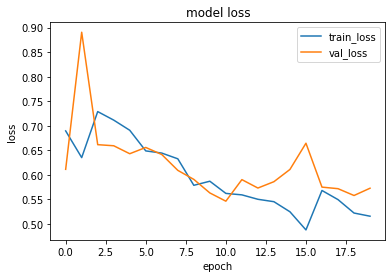

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.3462]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.48383334]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5753629]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.24133298]]


1it [00:00, 12985.46it/s]


prediction for video control_2.mov is [[0.22176728]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.2186229]]
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6720 - accuracy: 0.5000 - precision_192: 0.5179 - recall_192: 0.6905 - val_loss: 0.7387 - val_accuracy: 0.4000 - val_precision_192: 0.3889 - val_recall_192: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6484 - accuracy: 0.6250 - precision_192: 0.6200 - recall_192: 0.7381 - val_loss: 0.7113 - val_accuracy: 0.7000 - val_precision_192: 0.5833 - val_recall_192: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.5935 - accuracy: 0.7125 - precision_192: 0.6939 - recall_192: 0.8095 - val_loss: 0.6863 - val_accuracy: 0.7500 - val_precision_192: 0.6154 - val_recall_192: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5749 - accuracy: 0.7250 - precision_192: 0.7174 - recall_192: 0.7857 - val_loss: 0.6747 - val_accuracy: 0.6500 - val_precision_192: 0.5556 - val_recall_192: 0.6

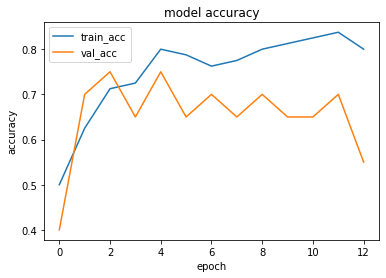

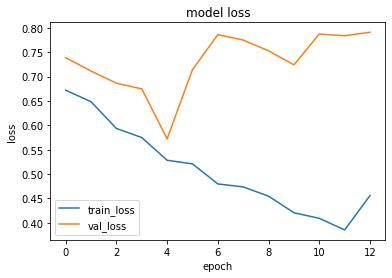

1it [00:00, 11781.75it/s]


prediction for video armflapping_1.mov is [[0.60937715]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.74313706]]


1it [00:00, 13025.79it/s]


prediction for video armflapping_2.mov is [[0.738742]]


1it [00:00, 11214.72it/s]


prediction for video control_1.mov is [[0.45578033]]


1it [00:00, 13934.56it/s]


prediction for video control_2.mov is [[0.35387492]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.32761896]]
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6626 - accuracy: 0.5375 - precision_193: 0.5472 - recall_193: 0.6905 - val_loss: 0.7117 - val_accuracy: 0.4500 - val_precision_193: 0.3846 - val_recall_193: 0.6250
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6533 - accuracy: 0.6125 - precision_193: 0.6410 - recall_193: 0.5952 - val_loss: 0.6507 - val_accuracy: 0.7000 - val_precision_193: 0.6250 - val_recall_193: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6168 - accuracy: 0.7000 - precision_193: 0.6800 - recall_193: 0.8095 - val_loss: 0.6232 - val_accuracy: 0.7000 - val_precision_193: 0.6250 - val_recall_193: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.5663 - accuracy: 0.7375 - precision_193: 0.7234 - recall_193: 0.8095 - val_loss: 0.5727 - val_accuracy: 0.8000 - val_precision_193: 0.8333 - val_recall_193: 0.

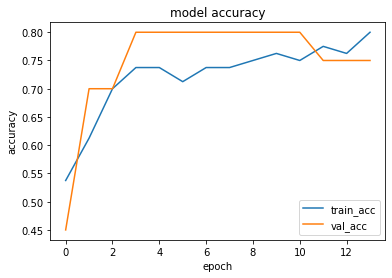

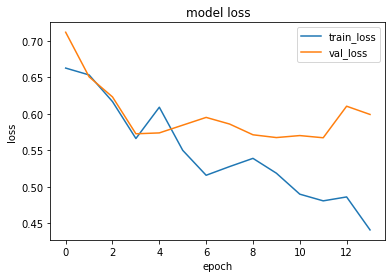

1it [00:00, 13662.23it/s]


prediction for video armflapping_1.mov is [[0.49997833]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5452285]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.6718155]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.19564569]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.1514822]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.15373018]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6703 - accuracy: 0.5750 - precision_194: 0.6316 - recall_194: 0.3077 - val_loss: 0.7893 - val_accuracy: 0.5500 - val_precision_194: 0.5556 - val_recall_194: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.7102 - accuracy: 0.6125 - precision_194: 0.5667 - recall_194: 0.8718 - val_loss: 0.6180 - val_accuracy: 0.8000 - val_precision_194: 0.7692 - val_recall_194: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6461 - accuracy: 0.6625 - precision_194: 0.7000 - recall_194: 0.5385 - val_loss: 0.5927 - val_accuracy: 0.8000 - val_precision_194: 0.8889 - val_recall_194: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6209 - accuracy: 0.6750 - precision_194: 0.7826 - recall_194: 0.4615 - val_loss: 0.5399 - val_accuracy: 0.8500 - val_precision_194: 0.8333 - val_recall_194: 0.

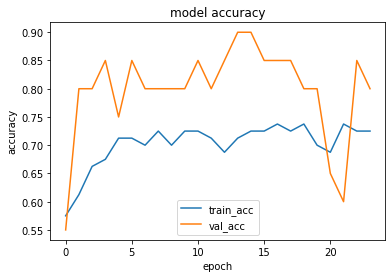

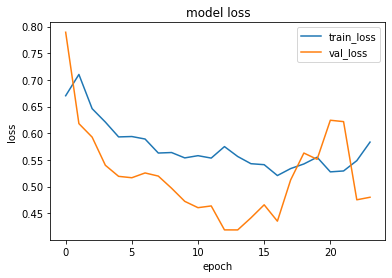

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.4352281]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.49350291]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_2.mov is [[0.58748144]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.25266516]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.22405869]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.2133232]]


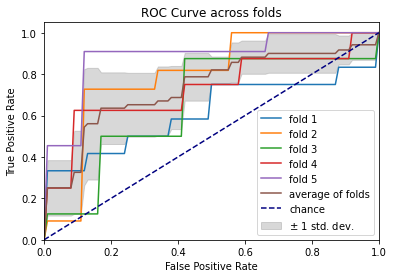

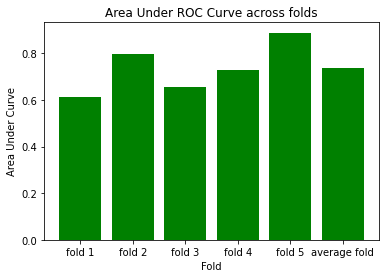

In [111]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6879 - accuracy: 0.6625 - precision_196: 0.6122 - recall_196: 0.7895 - val_loss: 0.6743 - val_accuracy: 0.6000 - val_precision_196: 0.6429 - val_recall_196: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 187ms/step - loss: 0.6402 - accuracy: 0.6625 - precision_196: 0.6774 - recall_196: 0.5526 - val_loss: 0.6445 - val_accuracy: 0.6500 - val_precision_196: 0.6923 - val_recall_196: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5890 - accuracy: 0.7500 - precision_196: 0.7250 - recall_196: 0.7632 - val_loss: 0.7442 - val_accuracy: 0.5500 - val_precision_196: 0.6000 - val_recall_196: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.5695 - accuracy: 0.7375 - precision_196: 0.6977 - recall_196: 0.7895 - val_loss: 0.7435 - val_accuracy: 0.5500 - val_precision_196: 0.6364 - val_recall_196: 0.5833
Epoch 5/75
3/3 [==============================] 

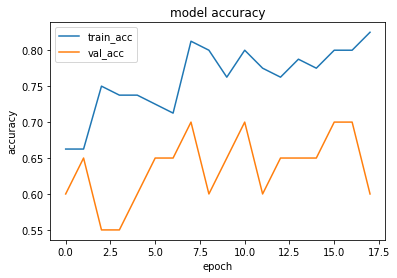

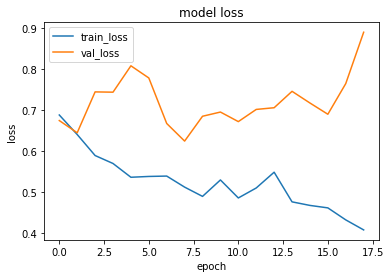

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.5028952]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_3.mov is [[0.59991807]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.63422555]]


1it [00:00, 13934.56it/s]


prediction for video control_1.mov is [[0.30231112]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.27122596]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.2657041]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6997 - accuracy: 0.4750 - precision_197: 0.4762 - recall_197: 0.7692 - val_loss: 0.6694 - val_accuracy: 0.5500 - val_precision_197: 0.7500 - val_recall_197: 0.2727
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6886 - accuracy: 0.5500 - precision_197: 0.6154 - recall_197: 0.2051 - val_loss: 0.5987 - val_accuracy: 0.7500 - val_precision_197: 0.7500 - val_recall_197: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6428 - accuracy: 0.7000 - precision_197: 0.6531 - recall_197: 0.8205 - val_loss: 0.6141 - val_accuracy: 0.7000 - val_precision_197: 0.6923 - val_recall_197: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6422 - accuracy: 0.7125 - precision_197: 0.6818 - recall_197: 0.7692 - val_loss: 0.6009 - val_accuracy: 0.7500 - val_precision_197: 0.7500 - val_recall_197: 0.8

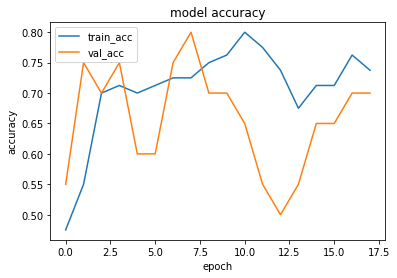

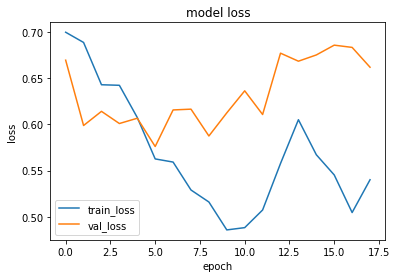

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.38928598]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.45773324]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.6035372]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.320629]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.27001992]]


1it [00:00, 16578.28it/s]


prediction for video control_3.mov is [[0.27036953]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6732 - accuracy: 0.5375 - precision_198: 0.5424 - recall_198: 0.7619 - val_loss: 0.6961 - val_accuracy: 0.5500 - val_precision_198: 0.4667 - val_recall_198: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5890 - accuracy: 0.6875 - precision_198: 0.6735 - recall_198: 0.7857 - val_loss: 0.6986 - val_accuracy: 0.7000 - val_precision_198: 0.5714 - val_recall_198: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5893 - accuracy: 0.7000 - precision_198: 0.6731 - recall_198: 0.8333 - val_loss: 0.6803 - val_accuracy: 0.6500 - val_precision_198: 0.5714 - val_recall_198: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.5485 - accuracy: 0.7500 - precision_198: 0.8235 - recall_198: 0.6667 - val_loss: 0.5916 - val_accuracy: 0.7000 - val_precision_198: 0.6250 - val_recall_198: 0.

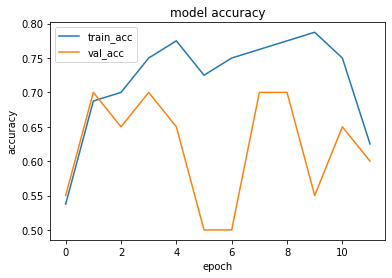

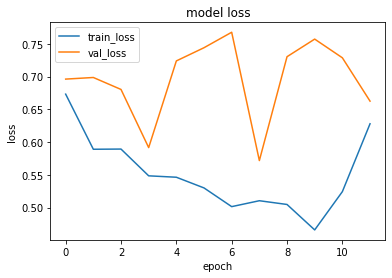

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.41102543]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_3.mov is [[0.5183948]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.48289862]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.36337593]]


1it [00:00, 11915.64it/s]


prediction for video control_2.mov is [[0.34661537]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.34128213]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7160 - accuracy: 0.4750 - precision_199: 0.5000 - recall_199: 0.4286 - val_loss: 0.6780 - val_accuracy: 0.4000 - val_precision_199: 0.3889 - val_recall_199: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6520 - accuracy: 0.5875 - precision_199: 0.5600 - recall_199: 1.0000 - val_loss: 0.6680 - val_accuracy: 0.4500 - val_precision_199: 0.4118 - val_recall_199: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6256 - accuracy: 0.6750 - precision_199: 0.6290 - recall_199: 0.9286 - val_loss: 0.6482 - val_accuracy: 0.8000 - val_precision_199: 0.8333 - val_recall_199: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5728 - accuracy: 0.7500 - precision_199: 0.7500 - recall_199: 0.7857 - val_loss: 0.6030 - val_accuracy: 0.7500 - val_precision_199: 0.6667 - val_recall_199: 0.

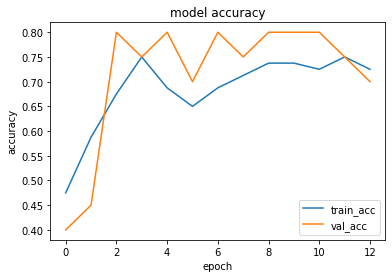

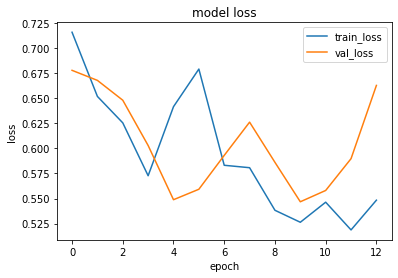

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.40976396]]


1it [00:00, 7397.36it/s]


prediction for video armflapping_3.mov is [[0.3135512]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.41027462]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.40107346]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.39851215]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.39749688]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6771 - accuracy: 0.6125 - precision_200: 0.6176 - recall_200: 0.5385 - val_loss: 0.6727 - val_accuracy: 0.6500 - val_precision_200: 0.6250 - val_recall_200: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6600 - accuracy: 0.6750 - precision_200: 0.6512 - recall_200: 0.7179 - val_loss: 0.6328 - val_accuracy: 0.6500 - val_precision_200: 1.0000 - val_recall_200: 0.3636
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6397 - accuracy: 0.6875 - precision_200: 0.7917 - recall_200: 0.4872 - val_loss: 0.5012 - val_accuracy: 0.9000 - val_precision_200: 0.9091 - val_recall_200: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5785 - accuracy: 0.6500 - precision_200: 0.6279 - recall_200: 0.6923 - val_loss: 0.5168 - val_accuracy: 0.8500 - val_precision_200: 0.9000 - val_recall_200: 0.

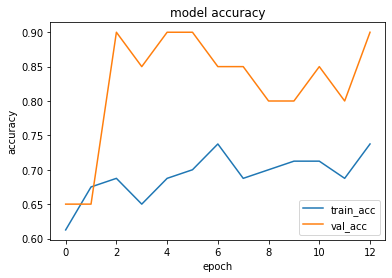

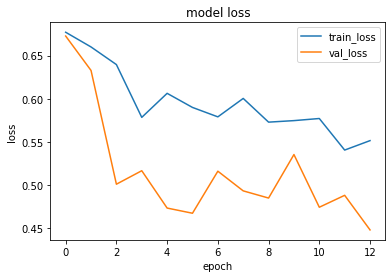

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.49240705]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5849636]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.59266144]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.38803536]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.35466903]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.34438962]]


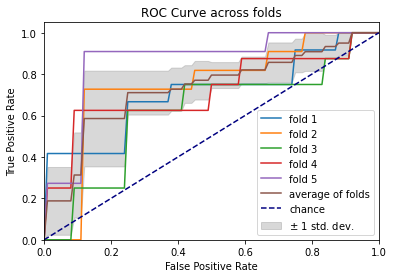

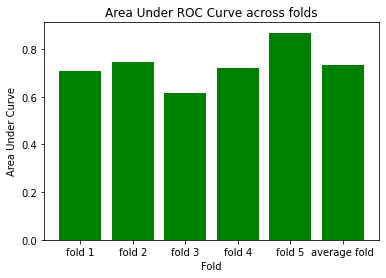

In [112]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 173ms/step - loss: 0.6845 - accuracy: 0.6000 - precision_202: 0.5625 - recall_202: 0.7105 - val_loss: 0.6589 - val_accuracy: 0.6500 - val_precision_202: 0.6923 - val_recall_202: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6740 - accuracy: 0.6125 - precision_202: 0.6522 - recall_202: 0.3947 - val_loss: 0.6613 - val_accuracy: 0.6000 - val_precision_202: 0.7000 - val_recall_202: 0.5833
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.5787 - accuracy: 0.7875 - precision_202: 0.7692 - recall_202: 0.7895 - val_loss: 0.7776 - val_accuracy: 0.5500 - val_precision_202: 0.6000 - val_recall_202: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.5792 - accuracy: 0.7125 - precision_202: 0.6744 - recall_202: 0.7632 - val_loss: 0.7935 - val_accuracy: 0.5500 - val_precision_202: 0.6154 - val_recall_202: 0.6667
Epoch 5/75
3/3 [==============================] 

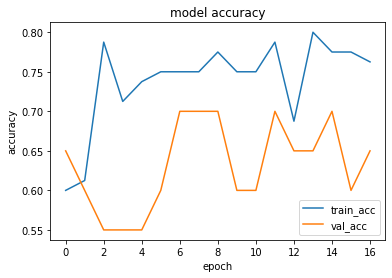

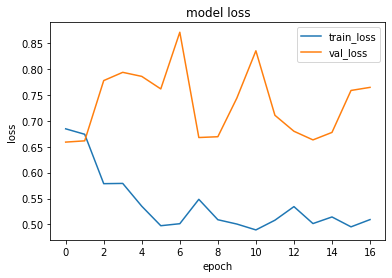

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5006436]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5599678]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.69313174]]


1it [00:00, 13486.51it/s]


prediction for video control_1.mov is [[0.06100944]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.04825941]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.05649343]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7064 - accuracy: 0.4375 - precision_203: 0.4531 - recall_203: 0.7436 - val_loss: 0.6284 - val_accuracy: 0.6000 - val_precision_203: 0.6154 - val_recall_203: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6401 - accuracy: 0.7000 - precision_203: 0.6667 - recall_203: 0.7692 - val_loss: 0.5720 - val_accuracy: 0.7500 - val_precision_203: 0.6875 - val_recall_203: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.5988 - accuracy: 0.7375 - precision_203: 0.7250 - recall_203: 0.7436 - val_loss: 0.5878 - val_accuracy: 0.7500 - val_precision_203: 0.8000 - val_recall_203: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6345 - accuracy: 0.6750 - precision_203: 0.6585 - recall_203: 0.6923 - val_loss: 0.7819 - val_accuracy: 0.6500 - val_precision_203: 0.6111 - val_recall_203: 1.

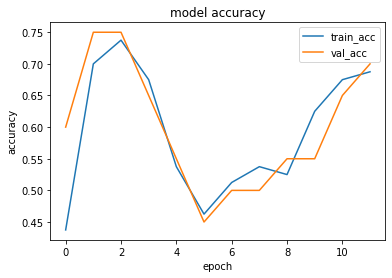

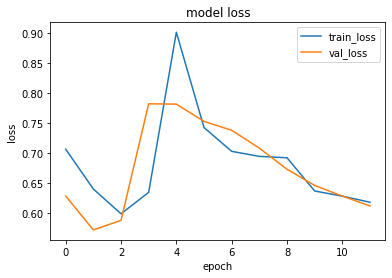

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.52991784]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.568154]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.60177237]]


1it [00:00, 12985.46it/s]


prediction for video control_1.mov is [[0.4947613]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.48038858]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.47261584]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6869 - accuracy: 0.5375 - precision_204: 0.5532 - recall_204: 0.6190 - val_loss: 0.7111 - val_accuracy: 0.4500 - val_precision_204: 0.4211 - val_recall_204: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6254 - accuracy: 0.5750 - precision_204: 0.5541 - recall_204: 0.9762 - val_loss: 0.6895 - val_accuracy: 0.4000 - val_precision_204: 0.3889 - val_recall_204: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6018 - accuracy: 0.6750 - precision_204: 0.6290 - recall_204: 0.9286 - val_loss: 0.6799 - val_accuracy: 0.6500 - val_precision_204: 0.5455 - val_recall_204: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5400 - accuracy: 0.7500 - precision_204: 0.7895 - recall_204: 0.7143 - val_loss: 0.6212 - val_accuracy: 0.7000 - val_precision_204: 0.7500 - val_recall_204: 0.

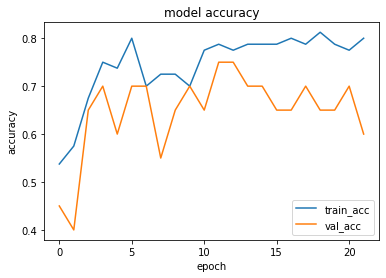

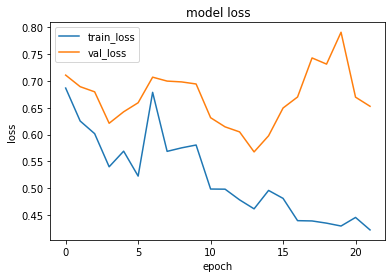

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.4576679]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.6616633]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.6191525]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.40752906]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.34736186]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.35331053]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6800 - accuracy: 0.5750 - precision_205: 0.5769 - recall_205: 0.7143 - val_loss: 0.7348 - val_accuracy: 0.4000 - val_precision_205: 0.3333 - val_recall_205: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6545 - accuracy: 0.5875 - precision_205: 0.5763 - recall_205: 0.8095 - val_loss: 0.6474 - val_accuracy: 0.7500 - val_precision_205: 0.7143 - val_recall_205: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5806 - accuracy: 0.7375 - precision_205: 0.7234 - recall_205: 0.8095 - val_loss: 0.6167 - val_accuracy: 0.8000 - val_precision_205: 0.8333 - val_recall_205: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5637 - accuracy: 0.7500 - precision_205: 0.7619 - recall_205: 0.7619 - val_loss: 0.5697 - val_accuracy: 0.8000 - val_precision_205: 0.8333 - val_recall_205: 0.

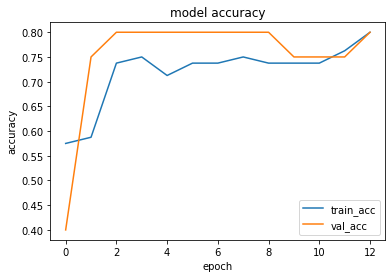

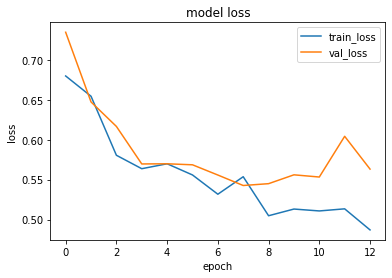

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.51231605]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.45832208]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.5601065]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.47143486]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.43384856]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.440625]]
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.7698 - accuracy: 0.4375 - precision_206: 0.4531 - recall_206: 0.7436 - val_loss: 0.6871 - val_accuracy: 0.6500 - val_precision_206: 0.6429 - val_recall_206: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6878 - accuracy: 0.5875 - precision_206: 0.6154 - recall_206: 0.4103 - val_loss: 0.6719 - val_accuracy: 0.5000 - val_precision_206: 1.0000 - val_recall_206: 0.0909
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6869 - accuracy: 0.5625 - precision_206: 0.6111 - recall_206: 0.2821 - val_loss: 0.6263 - val_accuracy: 0.8000 - val_precision_206: 0.7692 - val_recall_206: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6436 - accuracy: 0.6875 - precision_206: 0.6400 - recall_206: 0.8205 - val_loss: 0.5950 - val_accuracy: 0.7500 - val_precision_206: 0.7143 - val_recall_206: 0.90

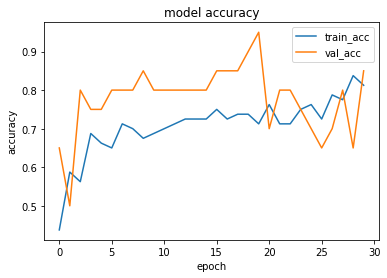

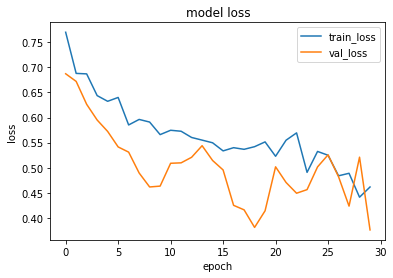

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.645128]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.72623307]]


1it [00:00, 11881.88it/s]


prediction for video armflapping_2.mov is [[0.66675234]]


1it [00:00, 20068.44it/s]


prediction for video control_1.mov is [[0.343305]]


1it [00:00, 12052.60it/s]


prediction for video control_2.mov is [[0.2418305]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.27281237]]


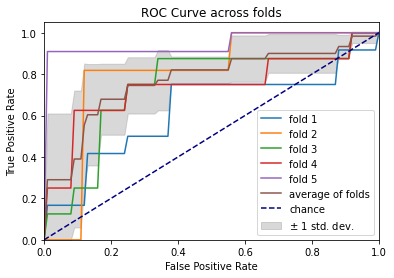

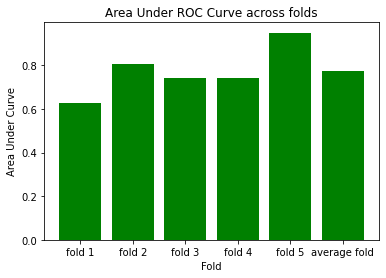

In [113]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

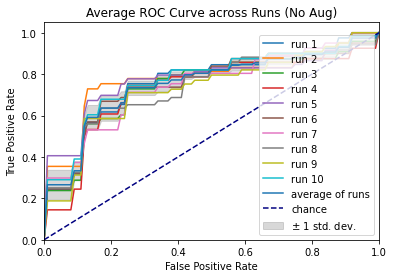

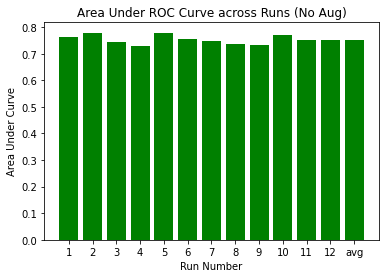

In [118]:
# plot and all there metrics there are 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [115]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

# this is with no augmentation BTW. 

(0.7535353535353536, 0.017230212345293244)